In [670]:
# Helper functions for preprocessing raw text before feeding it into a Neural Net
import string
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion

In [671]:
import os

class TextPair:
    def __init__(self, author, known, unknown, max_length=1200):
        self.author = author
        self.known = known
        self.unknown = unknown
        self.max_length = max_length

def get_string(filename):
    with open(filename, encoding="utf8") as f:
        s = f.read()
    return s

def get_texts(directory):
    authors = [x for x in os.listdir(directory) if x.startswith("E")]
    tps = []
    for author in authors:
        known = os.path.join(directory, author, "known01.txt")
        unknown = os.path.join(directory, author, "unknown.txt")
        tps.append(TextPair(author, get_string(known), get_string(unknown)))
    return tps

def get_data(directory):
    
    # read all texts into known, unknown pairs
    tps = get_texts(directory)
    
    # get labels
    truthfile = os.path.join(directory, "truth.txt")
    with open(truthfile) as f:
        lines = f.read().strip().split("\n")
    y = [1 if line.split()[1] == "Y" else 0 for line in lines]
    y = np.array(y)
    return tps, y

In [ ]:
pan15train = "/data/pan15-authorship-verification-training-dataset-english-2015-04-19/"
pan15test = "/data/pan15-authorship-verification-test-dataset2-english-2015-04-19/"
# pan15train = "/data/emails-train/"
# pan15test = "/data/emails-test/"

pan14train = "/data/pan14-author-verification-training-corpus-english-essays-2014-04-22/"
pan14test = "/data/pan14-author-verification-test-corpus2-english-essays-2014-04-22/"

# pan14train = "/data/pan14-author-verification-training-corpus-english-novels-2014-04-22/"
# pan14test = "/data/pan14-author-verification-test-corpus2-english-novels-2014-04-22/"


te_pairs, te_y = get_data(pan15test)
tr_pairs, tr_y = get_data(pan15train)

char_tf = TfidfVectorizer(analyzer='char', ngram_range=(2,4), min_df=0.3)
word_tf = TfidfVectorizer(ngram_range=(1,2), min_df=0.05)
vec = FeatureUnion([
    ('char', char_tf),
    ('word', word_tf)
])
vec.fit([tp.known for tp in te_pairs] + [tp.unknown for tp in te_pairs] +
         [tp.known for tp in tr_pairs] + [tp.unknown for tp in tr_pairs])



In [672]:
def normalize(text, target_length=1200):
    if len(text) > target_length:
        return text[:target_length]
    else:
        return text + ("$" * (target_length - len(text)))

def vectorize(texts, vec, target_length=1200):
    # texts = [normalize(text) for text in texts]
    return vec.transform(texts)

def create_pairs(knownX, unknownX):
    pairs = []
    for i in range(knownX.shape[0]):
        pairs += [[knownX[i], unknownX[i]]]
    pairs = np.array(pairs)
    print(pairs.shape)
    return pairs    

In [602]:
train_known_X = vectorize([tp.known for tp in tr_pairs], vec)
train_unknown_X = vectorize([tp.unknown for tp in tr_pairs], vec)

In [603]:
test_known_X = vectorize([tp.known for tp in te_pairs], vec)
test_unknown_X = vectorize([tp.unknown for tp in te_pairs], vec)

In [604]:
train_known_X = train_known_X.todense()
train_unknown_X = train_unknown_X.todense()
test_known_X = test_known_X.todense()
test_unknown_X = test_unknown_X.todense()

In [674]:
def create_vectorized_pairs(knowntexts, unknowntexts, vec):
    known_X = vectorize([text for text in knowntexts], vec).todense()
    unknown_X = vectorize([text for text in unknowntexts], vec).todense()
    pairs = create_pairs(known_X, unknown_X)
    pairs = pairs.squeeze()
    print(pairs.shape)
    return pairs

In [606]:
tr_pairs = create_pairs(train_known_X, train_unknown_X)
te_pairs = create_pairs(test_known_X, test_unknown_X)

(100, 2, 1, 4187)
(500, 2, 1, 4187)


In [607]:
tr_pairs = tr_pairs.squeeze()
te_pairs = te_pairs.squeeze()

In [608]:
tr_pairs.shape

(100, 2, 4187)

In [669]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
np.random.seed(1337)  # for reproducibility

import random
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda
from keras.optimizers import RMSprop
from keras import backend as K


def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

def create_base_network(input_dim):
    '''Base network to be shared (eq. to feature extraction).
    '''
    seq = Sequential()
    seq.add(Dense(256, input_shape=(input_dim,), activation='relu'))
    seq.add(Dense(256, activation='relu'))      
    seq.add(Dense(256, activation='relu'))
    seq.add(Dense(256, activation='relu'))
    seq.add(Dense(256, activation='relu'))
    return seq


def compute_accuracy(predictions, labels):
    return np.mean(np.equal(predictions.ravel() < 0.5, labels))

In [647]:
input_dim = tr_pairs.shape[-1]

# network definition
base_network = create_base_network(input_dim)

input_a = Input(shape=(input_dim,))
input_b = Input(shape=(input_dim,))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model(inputs=[input_a, input_b], outputs=distance)

In [648]:
# train
"""
tr_pairs1 = tr_pairs[:250]
te_pairs1 = tr_pairs[250:]
tr_y1 = tr_y[:250]
te_y1 = tr_y[250:]

tr_pairs = tr_pairs1
te_pairs = te_pairs1
tr_y = tr_y1
te_y = te_y1
"""
# tr_pairs = np.vstack([tr_pairs, te_pairs])
# print(tr_pairs.shape)

rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms)
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          validation_split=0.001,
          batch_size=20,
          epochs=20)



Train on 99 samples, validate on 1 samples
Epoch 1/20
99/99 [==============================] - 2s - loss: 0.2494 - val_loss: 0.0995
Epoch 2/20
99/99 [==============================] - 0s - loss: 0.1217 - val_loss: 0.0554
Epoch 3/20
99/99 [==============================] - 0s - loss: 0.0444 - val_loss: 0.0062
Epoch 4/20
99/99 [==============================] - 0s - loss: 0.0303 - val_loss: 0.0423
Epoch 5/20
99/99 [=========

In [650]:
# compute final accuracy on training and test sets
pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(pred, tr_y)
pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(pred, te_y)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 99.00%
* Accuracy on test set: 81.20%


In [668]:
from collections import Counter
from sklearn.metrics import classification_report
preds = [1 if p[0] < 0.8 else 0 for p in pred]
print(Counter(preds))
print(classification_report(te_y, preds))

Counter({1: 371, 0: 129})
             precision    recall  f1-score   support

          0       0.95      0.49      0.65       250
          1       0.66      0.98      0.79       250

avg / total       0.81      0.73      0.72       500



In [693]:
pan14train = "/data/pan14-author-verification-training-corpus-english-novels-2014-04-22/"
pan14test = "/data/pan14-author-verification-test-corpus2-english-novels-2014-04-22/"

p14_tr_texts, p14_tr_labels = get_data(pan14train)
p14_tr_pairs = create_vectorized_pairs([tp.known for tp in p14_tr_texts], [tp.unknown for tp in p14_tr_texts], vec)

p14_te_texts, p14_te_labels = get_data(pan14test)
p14_te_pairs = create_vectorized_pairs([tp.known for tp in p14_te_texts], [tp.unknown for tp in p14_te_texts], vec)

(100, 2, 1, 4187)
(100, 2, 4187)
(200, 2, 1, 4187)
(200, 2, 4187)


In [704]:
c50_known, c50_unknown, c50_labels = load_C50("/data/C50/C50TrainVerification/")
c50_pairs = create_vectorized_pairs(c50_known, c50_unknown, vec)

(50, 2, 1, 4187)
(50, 2, 4187)


In [705]:
# pred = model.predict([p14_te_pairs[:, 0], p14_te_pairs[:, 1]])
pred = model.predict([c50_pairs[:, 0], c50_pairs[:, 1]])

In [746]:
preds = [1 if p[0] < 0.0772 else 0 for p in pred]
print(Counter(preds))
print(classification_report(c50_labels, preds))


Counter({1: 25, 0: 25})
             precision    recall  f1-score   support

          0       0.72      0.72      0.72        25
          1       0.72      0.72      0.72        25

avg / total       0.72      0.72      0.72        50



In [703]:
def load_C50(directory):
    def read_file(path):
        with open(path) as f:
            return f.read()
    """Load known and unknown texts in the PAN data format"""
    # FIXME: assumes one known file per author, which is fine for English datasets only
    authors = sorted([x for x in os.listdir(directory)])
    known_texts = []
    unknown_texts = []
    for author in authors:
        kf = os.path.join(directory, author, "known.txt")
        uf = os.path.join(directory, author, "unknown.txt")
        known_texts.append(read_file(kf))
        unknown_texts.append(read_file(uf))
    y = [1] * 25 + [0] * 25
    return known_texts, unknown_texts, y

'The Internet may be overflowing with new technology but crime in cyberspace is still of the old-fashioned variety.\nThe National Consumers League said Wednesday that the most popular scam on the Internet was the pyramid scheme, in which early investors in a bogus fund are paid off with deposits of later investors.\nThe league, a non-profit consumer advocacy group, tracks web scams through a site it set up on the world wide web in February called Internet Fraud Watch at http://www.fraud.org.\nThe site, which collects reports directly from consumers, has been widely praised by law enforcement agencies.\n"Consumers who suspect a scam on the Internet have critical information," said Jodie Bernstein, director of the Federal Trade Commission\'s Bureau of Consumer Protection. Internet Fraud Watch "has been a major help to the FTC in identifying particular scams in their infancy."\nIn May, for example, the commission used Internet reports to shut down a site run by Fortuna Alliance that had t

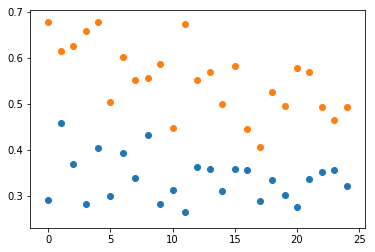

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [761]:
from scipy.spatial.distance import euclidean, cosine
%matplotlib inline
from matplotlib import pyplot as plt

def plot(tr_pairs, tr_y):
    eucs = [euclidean(tr_pairs[i][0], tr_pairs[i][1]) for i in range(len(tr_pairs))]
    coss = [cosine(tr_pairs[i][0], tr_pairs[i][1]) for i in range(len(tr_pairs))]



    same = [x for i, x in enumerate(eucs) if tr_y[i]]
    diff = [x for i, x in enumerate(eucs) if not tr_y[i]]
    plt.scatter(range(len(same)), same)
    plt.scatter(range(len(same)), diff)
    plt.show()
    return eucs, coss

e, c = plot(c50_pairs, c50_labels)
c50_labels

In [156]:
eucs[0]

0.9210017367864325

In [157]:
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

cross_val_score(DecisionTreeClassifier(), [[x] for x in coss], tr_y)

array([ 0.63095238,  0.65662651,  0.70481928])

In [146]:
tr_pairs.shape

(500, 2, 46519)

In [216]:
te_pairs[:,0].shape

(500, 1200)

In [219]:
np.hstack([tr_y,te_y])

array([1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 1,